In [1]:
## Data manipulation
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import xlrd as xlrd
import csv
import pandas_datareader as web
from matplotlib.ticker import FuncFormatter
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm

## Plotting
import matplotlib.pyplot as plt
import seaborn
import matplotlib.mlab as mlab

## Statistical calculation
from scipy.stats import norm

## Data fetching
#import fix_yahoo_finance as yf
import yfinance as yf
import datetime as dt

## Tabular data output
from tabulate import tabulate

%matplotlib inline

In [15]:
brkb = yf.download(tickers="BRK-B", interval="1d", start="2013-5-13", end="2023-2-23")
ritm  = yf.download(tickers="RITM", interval="1d", start="2013-5-13", end="2023-2-23")
jpm = yf.download(tickers="JPM", interval="1d", start="2013-5-13", end="2023-2-23")
frc = yf.download(tickers="FRC", interval="1d", start="2013-5-13", end="2023-2-23")
msft = yf.download(tickers="MSFT", interval="1d", start="2013-5-13", end="2023-2-23")
ulst = yf.download(tickers="ULST", interval="1d", start="2013-5-13", end="2023-2-23")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [16]:
stock_downloaded = [brkb, ritm, jpm, frc, msft, ulst]

for stock in stock_downloaded:
    stock.reset_index(inplace = True)
    stock["Date"] = pd.to_datetime(stock["Date"], format = "%Y-%m-%d")

In [22]:
# AAPL import
data = pd.read_excel("AAPL.xlsx")
data = data.rename(columns = {"Last Price": "Last Price_AAPL"})

In [23]:
# Combine data
stock_names = ["BRK-B", "RITM", "JPM", "FRC", "MSFT", "ULST"]

for i in range(len(stock_downloaded)):
    stock_downloaded[i][f"Last Price_{stock_names[i]}"] = stock_downloaded[i]["Close"]
    data = (pd.merge(data,
                    stock_downloaded[i][["Date", f"Last Price_{stock_names[i]}"]],
                    on = "Date",
                    how = "left"))

In [26]:
data = data.sort_values(by = "Date", ascending = True)
data = data.dropna()

In [27]:
totalPer = 100 - 30.3
stocks = ["AAPL", "BRK-B", "RITM", "JPM", "FRC", "MSFT", "ULST"]
percentage = [11.3, 12.3, 4.1, 9.9, 1.7, 20.3, 20.1]
data["portfolio"] = ((11.3 / totalPer) * data["Last Price_AAPL"] + 
                    (12.3 / totalPer) * data["Last Price_BRK-B"] + 
                    (4.1 / totalPer) * data["Last Price_RITM"] +
                    (9.9 / totalPer) * data["Last Price_JPM"] +
                    (1.7 / totalPer) * data["Last Price_FRC"] +
                    (20.3 / totalPer) * data["Last Price_MSFT"] +
                    (20.1 / totalPer) * data["Last Price_ULST"])
column_names = list(data.columns.values)
data = data.select_dtypes(include=['number']) #remove the data column in the original dataset

In [28]:
data_return = data.pct_change()
data_return

,Last Price_AAPL,Last Price_BRK-B,Last Price_RITM,Last Price_JPM,Last Price_FRC,Last Price_MSFT,Last Price_ULST,portfolio
489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488,0.032670,0.010016,0.042424,0.034089,0.044920,0.024319,0.000000,0.016225
487,0.033508,0.000513,-0.004360,-0.028177,0.023905,0.022025,-0.000250,0.002522
486,-0.011233,-0.015039,-0.036496,-0.004927,-0.006082,-0.005598,0.000250,-0.008588
485,0.000969,0.005292,-0.071212,0.027614,0.006514,0.063327,-0.000250,0.016843
...,...,...,...,...,...,...,...,...
4,0.058461,-0.002259,0.033223,0.038792,0.035468,0.033053,0.001245,0.024171
3,0.058727,-0.002135,0.013934,0.005487,0.024750,0.041062,-0.002488,0.023731
2,-0.022589,0.004473,0.002114,-0.000354,-0.062630,0.018386,0.000249,0.004398
1,0.010198,-0.005325,0.004220,0.008508,-0.048431,-0.019156,0.000748,-0.007780


$$
S_{t+1}=S_t+S_t(\mu\Delta t+\varepsilon\sigma\sqrt{\Delta t})
$$

In [29]:
mean = data_return.mean() # return of asset
vol = data_return.std() #volatility

In [32]:
# Define several delta t
time3 = 1 / (252 * 3)  
time5 = 1 / (252 * 5)
time7 = 1 / (252 * 7)
time2 = 1 / (252 * 2)
time1 = 1 / (252)
time6mo = 1 / (126)

In [33]:
def MeanTime(t):
    if t == time3:
        mean_time = mean * time3     
    elif t == time5:
        mean_time = mean * time5
    elif t == time7:
        mean_time = mean * time7 
    elif t == time2:
        mean_time = mean * time2
    elif t == time1:
        mean_time = mean * time1
    else:
        mean_time = mean * time6mo
    return mean_time

#mean_time = mean * time # /mu /delta t term in the equation
MeanTime(time7)

Last Price_AAPL     3.001651e-06
Last Price_BRK-B    1.355123e-06
Last Price_RITM     6.239582e-07
Last Price_JPM      1.549405e-06
Last Price_FRC      1.601498e-06
Last Price_MSFT     2.728281e-06
Last Price_ULST     3.917747e-09
portfolio           1.640206e-06
dtype: float64

In [34]:
#vol_time = vol * np.sqrt(time)  # /sigma /sqrt /delta t term in the equation above
def VolTime(t):
    if t == time3:
        vol_time = vol * np.sqrt(time3)
    elif t == time5:
        vol_time = vol * np.sqrt(time5)
    elif t == time7:
        vol_time = vol * np.sqrt(time7)
    elif t == time2:
        vol_time = vol * np.sqrt(time2)
    elif t == time1:
        vol_time = vol * np.sqrt(time1)
    else:
        vol_time = vol * np.sqrt(time6mo)
    return vol_time

VolTime(time7)

Last Price_AAPL     0.000934
Last Price_BRK-B    0.000632
Last Price_RITM     0.001405
Last Price_JPM      0.000863
Last Price_FRC      0.000964
Last Price_MSFT     0.000801
Last Price_ULST     0.000049
portfolio           0.000559
dtype: float64

In [35]:
iteration = 10
t_interval = 10000 #10000 time intervals, iterate 10 times for each time interval

In [36]:
ran = norm.ppf(np.random.rand(t_interval, iteration)) # /epsilon term in the above equation
ran

array([[-1.83856001,  0.12094883, -0.22642266, ...,  0.19441013,
         0.38036354, -0.3140417 ],
       [-0.27873135,  0.21656932, -1.23947029, ..., -1.75343514,
         1.9030242 , -0.73297181],
       [ 0.89677571, -0.67168543, -0.34356851, ...,  0.15938164,
        -1.70121843,  0.69960678],
       ...,
       [ 1.09332235, -0.90789955,  0.99863146, ..., -0.22159245,
        -1.8360939 ,  0.31627424],
       [-0.85764641,  0.36239391, -1.01384117, ...,  0.67906195,
        -0.16723424,  0.39303889],
       [ 1.12470322, -1.43096585, -0.18756301, ..., -0.05446589,
         0.02491698,  2.30121516]])

$$
S_{t+1}=S_t+S_t(\mu\Delta t+\varepsilon\sigma\sqrt{\Delta t})
$$

In [40]:
def VaR_Calculation(time): 
    ncol = data.shape[1]
    for i in range(ncol): #iterate for each equity
        ran_factor = MeanTime(time)[i] + VolTime(time)[i] * ran # /mu*/delta t + /sigma * /epsilon * /sqrt /delta t
        S0 = data.iloc[:,[i]].iloc[-1]
        price_list = np.zeros_like(ran_factor)
        price_list[0] = S0
        for j in range(1, t_interval):
            price_list[j] = price_list[j-1] + price_list[j-1] * ran_factor[j] # the formula
        new_price = pd.DataFrame(price_list)
        #VaR = S0 - np.percentile(new_price, 95)
        VaR95 = np.percentile(new_price, 5)-S0
        VaR99 = np.percentile(new_price, 1)-S0
        VaR95_percent = (np.percentile(new_price, 5)-S0)/S0 #95%
        VaR99_percent = (np.percentile(new_price, 1)-S0)/S0
    new_price.pct_change().hist(figsize=(12,12), bins = 100) #histogram of percent change of price
    new_price.plot(figsize=(10,10))
    return print(f"VaR95:\t{VaR95}"), print(f"Var99:\t{VaR99}"), print(f"VaR95%:\t{VaR95_percent}"), print(f"VaR99%:\t{VaR99_percent}") # the printed dollar value is at risk    

VaR95:	portfolio   -12.63737
Name: 0, dtype: float64
Var99:	portfolio   -20.62299
Name: 0, dtype: float64
VaR95%:	portfolio   -0.067933
Name: 0, dtype: float64
VaR99%:	portfolio   -0.110859
Name: 0, dtype: float64


(None, None, None, None)

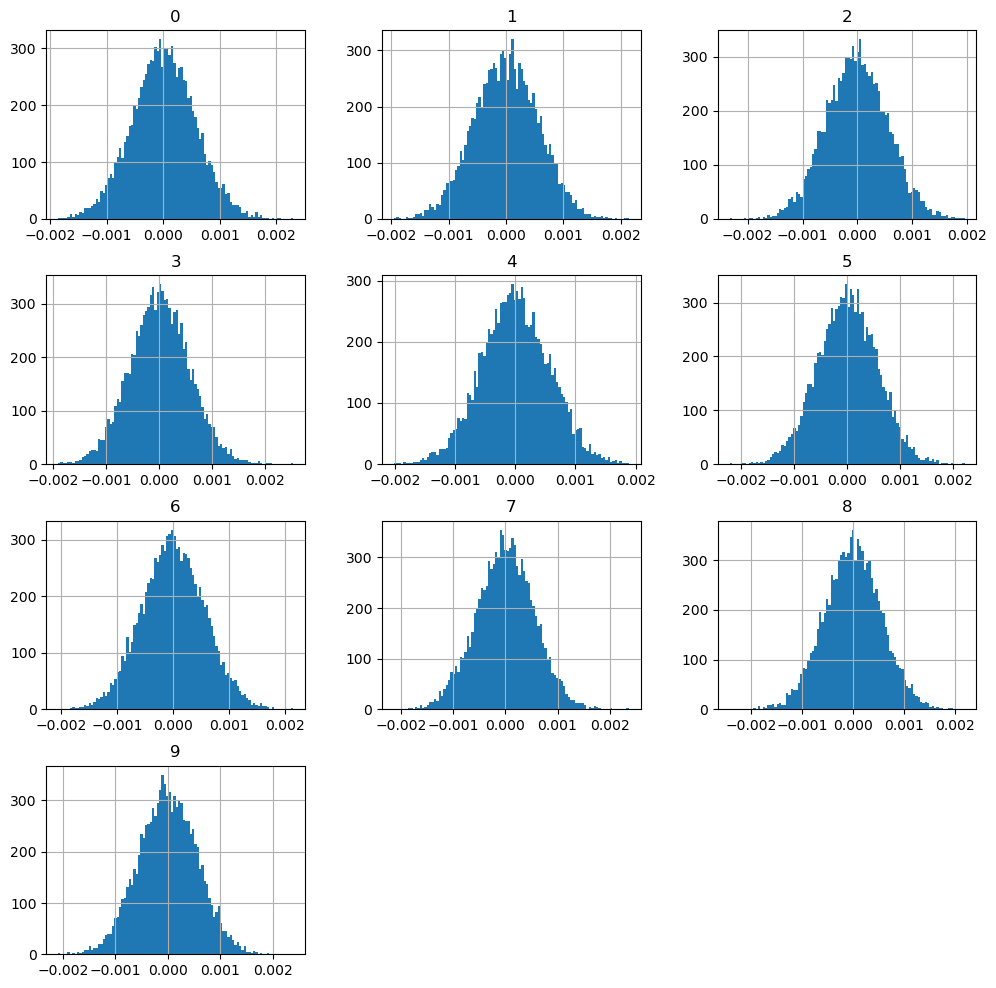

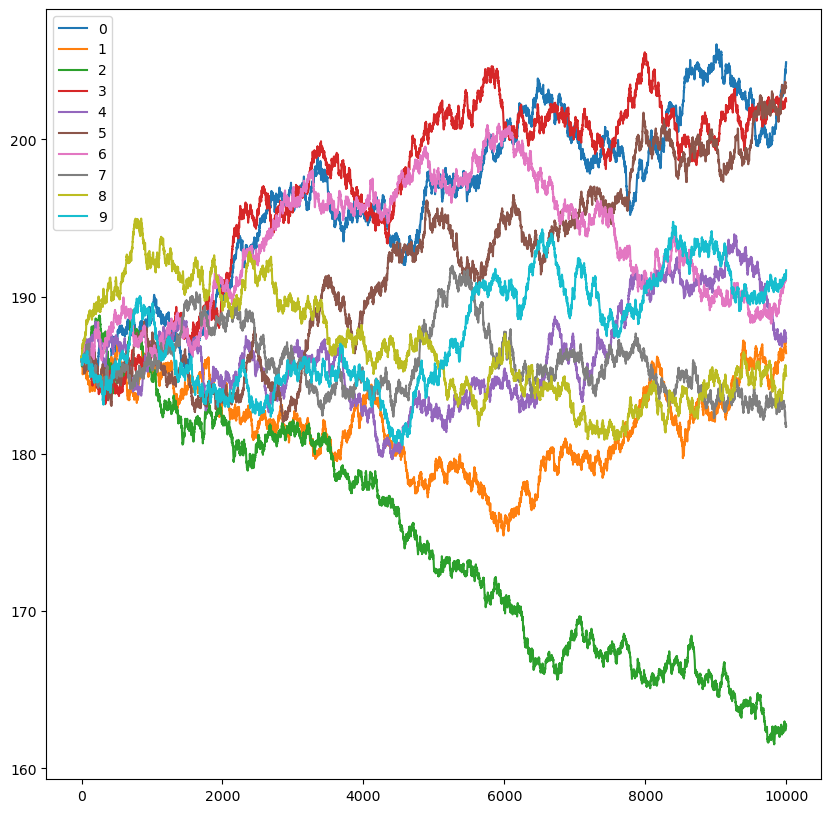

In [42]:
# Time choose from: time3, time5, time7, time2, time1, time6mo

VaR_Calculation(time7)